noskievic

In [21]:
def noskievic(t, alpha, beta, a, b):
    import numpy as np
    d = alpha/beta
    tau = beta*t
    if np.isclose(d,0.0):
        print("d=0")
        f0 = 1 - np.cos(tau)
        f1 = 1 - ((np.sin(tau))/(tau))
    elif np.isclose(d,1.0):
        print("d=1")
        f0 = 1 - (1 + tau)*np.exp(-tau)
        f1 = 1 - 2*((1 - np.exp(-tau))/(tau)) + np.exp(-tau)
    elif -1 < d and d < 1:
        e = (d**2 - 0.5)/(d*np.sqrt(1 - d**2))
        w = np.sqrt(1 - d**2)
        f0 = 1 - np.exp(-d*tau)*((d/w)*np.sin(w*tau) + np.cos(w*tau))
        f1 = 1 - ((2*d)/(tau))*(1 - np.exp(-d*tau)*( np.cos(w*tau) + e*np.sin(w*tau) ))
    elif d > 1:
        d_0 = d + np.sqrt(d**2 - 1)
        f0 = 1 - (1/(d_0**2 - 1))*(d_0**2 * np.exp(-tau/d_0) - np.exp(-d_0 * tau))
        f1 = 1 - (1/tau)*(2*d - (1/(d_0*(d_0**2-1)))*( np.exp(-d_0*tau) - d**4*np.exp(-tau/d_0) )  )
    else:
        raise ValueError("d is not within bounds")

    return a*f0 + b*f1

noskievic(np.array([0.0001,0.1,0.2,0.3,0.4,0.5]),2,1,1,2)
    

array([-8.62157596e+04, -8.41671517e+01, -4.10293280e+01, -2.66304660e+01,
       -1.94167355e+01, -1.50776049e+01])

--- Weibull Analysis Started ---

Step 1: Preparing Data...
ML_final used for normalization: 33.00 mg
Number of data points for Weibull plot: 14

Step 2: Transforming Data and Estimating Parameters...
Estimated Beta (shape parameter): 1.887
Estimated Eta (scale parameter/characteristic time): 11.267 h
R-squared for the fit: 0.9993

Step 3: Calculating Key Erosion Parameters...
Time to reach F(t)=0.01% (proxy for practical incubation): 0.086 h
Calculated t_MER: 7.553 h
Calculated t_in (Nominal Incubation Time): 2.443 h
Calculated t_threshold (for F(t)=1.0%): 0.984 h

--- Weibull Analysis Finished ---


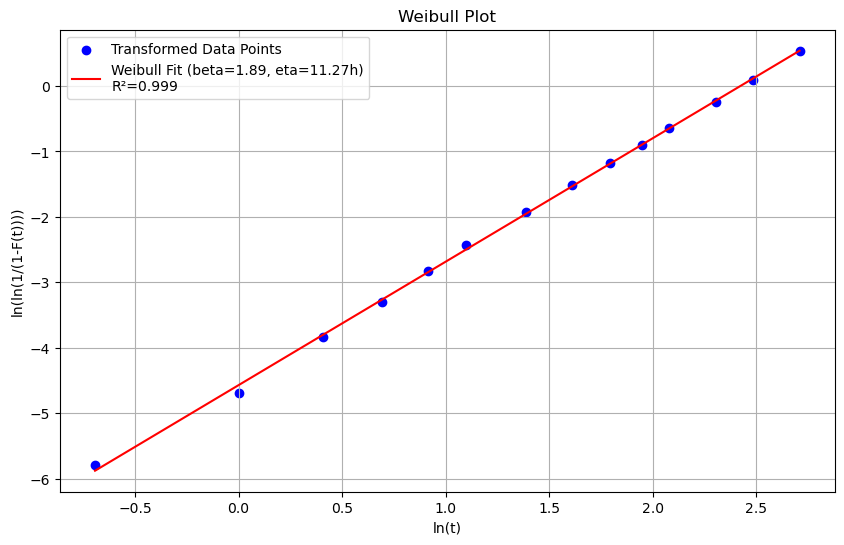

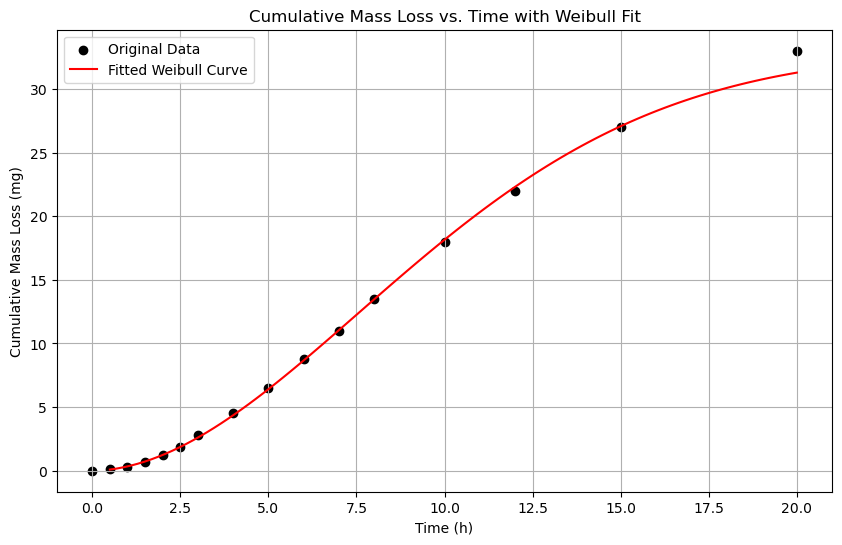

In [2]:
import numpy as np
from scipy.stats import linregress

# --- Step 1: Data Preparation ---
def prepare_data(times, cumulative_mass_loss):
    """
    Converts cumulative mass loss to cumulative fraction failed F(t).

    Args:
        times (np.array): Array of time points.
        cumulative_mass_loss (np.array): Array of cumulative mass loss values.

    Returns:
        tuple: (filtered_times, F_t_values, ml_final)
               filtered_times: Times corresponding to valid F(t) values.
               F_t_values: Cumulative fraction failed.
               ml_final: The final (maximum) mass loss used for normalization.
    """
    if len(times) != len(cumulative_mass_loss):
        raise ValueError("Times and cumulative_mass_loss arrays must have the same length.")
    if not len(times):
        raise ValueError("Input arrays cannot be empty.")

    # Use the maximum observed mass loss as ML_final
    ml_final = np.max(cumulative_mass_loss)
    if ml_final == 0:
        print("Warning: ML_final is 0. F(t) cannot be calculated properly. Returning empty arrays.")
        return np.array([]), np.array([]), 0

    # Calculate F(t) = ML_i / ML_final
    F_t_values = cumulative_mass_loss / ml_final

    # Filter out data points where F(t) is 0 or 1, or time is 0, as these
    # cannot be used in the logarithmic transformations for Weibull plotting.
    # We need 0 < F(t) < 1 and t > 0.
    valid_indices = (F_t_values > 0) & (F_t_values < 1) & (times > 0)
    
    filtered_times = times[valid_indices]
    filtered_F_t = F_t_values[valid_indices]

    if len(filtered_times) == 0:
        print("Warning: No valid data points after filtering for 0 < F(t) < 1 and t > 0.")
        
    return filtered_times, filtered_F_t, ml_final

# --- Step 2: Weibull Plotting and Parameter Estimation ---
def transform_for_weibull_plot(times, F_t_values):
    """
    Transforms data for Weibull plotting.
    X = ln(t)
    Y = ln(ln(1 / (1 - F(t))))

    Args:
        times (np.array): Array of time points (already filtered, t > 0).
        F_t_values (np.array): Array of F(t) values (already filtered, 0 < F(t) < 1).

    Returns:
        tuple: (X_weibull, Y_weibull)
    """
    if not len(times): # Should be caught by prepare_data, but good to have a check
        return np.array([]), np.array([])

    X_weibull = np.log(times)
    Y_weibull = np.log(np.log(1 / (1 - F_t_values)))
    return X_weibull, Y_weibull

def estimate_weibull_parameters(X_weibull, Y_weibull):
    """
    Estimates Weibull parameters eta and beta using linear regression.
    Y = beta * X - beta * ln(eta)
    Slope m = beta
    Intercept c = -beta * ln(eta) => eta = exp(-c / beta)

    Args:
        X_weibull (np.array): Transformed time data (ln(t)).
        Y_weibull (np.array): Transformed F(t) data (ln(ln(1/(1-F(t))))).

    Returns:
        tuple: (beta, eta, r_squared) or (None, None, None) if regression fails.
               beta: Shape parameter.
               eta: Scale parameter (characteristic time).
               r_squared: Coefficient of determination for the fit.
    """
    if len(X_weibull) < 2 or len(Y_weibull) < 2:
        print("Warning: Not enough data points for linear regression.")
        return None, None, None

    slope, intercept, r_value, p_value, std_err = linregress(X_weibull, Y_weibull)

    beta = slope
    if beta == 0: # Avoid division by zero
        print("Warning: Estimated beta (slope) is 0. Cannot calculate eta.")
        return beta, None, r_value**2
        
    eta = np.exp(-intercept / beta)
    r_squared = r_value**2
    
    return beta, eta, r_squared

# --- Step 3: Calculating Key Erosion Parameters ---
def calculate_t_mer(eta, beta):
    """
    Calculates Time at Maximum Erosion Rate (t_MER).
    t_MER = eta * ((beta - 1) / beta)^(1 / beta)
    Valid for beta > 1.

    Args:
        eta (float): Scale parameter.
        beta (float): Shape parameter.

    Returns:
        float: t_MER, or None if beta <= 1 or parameters are invalid.
    """
    if eta is None or beta is None:
        return None
    if beta <= 1:
        print(f"Warning: beta ({beta:.2f}) <= 1. t_MER is not well-defined or occurs at t=0.")
        return 0 # Or None, depending on desired interpretation
    
    try:
        t_mer = eta * ((beta - 1) / beta)**(1 / beta)
    except (ZeroDivisionError, TypeError, ValueError) as e:
        print(f"Error calculating t_MER: {e}")
        return None
    return t_mer

def calculate_t_in(eta, beta, t_mer):
    """
    Calculates Nominal Incubation Time (t_in).
    k = exp(-(t_MER / eta)^beta)
    t_in = t_MER - (1 - k) / ((beta / eta^beta) * t_MER^(beta - 1) * k)

    Args:
        eta (float): Scale parameter.
        beta (float): Shape parameter.
        t_mer (float): Time at Maximum Erosion Rate.

    Returns:
        float: t_in, or None if inputs are invalid.
    """
    if eta is None or beta is None or t_mer is None or t_mer < 0: # t_mer can be 0 if beta <=1
        return None
    if eta == 0: # Avoid division by zero
        print("Warning: eta is 0 in calculate_t_in.")
        return None

    try:
        # Handle t_mer = 0 case (e.g., when beta is close to 1)
        if t_mer == 0:
             # If t_MER is 0, the tangent starts at the origin, so t_in would also be 0.
             # This aligns with MER occurring at t=0 for beta=1.
            return 0

        k = np.exp(-(t_mer / eta)**beta)
        
        if k == 0: # Avoid division by zero in the denominator
            print("Warning: k is 0 in t_in calculation. Denominator would be zero.")
            # This can happen if (t_mer/eta)^beta is very large.
            # If k=0, it implies F(t_MER) is 1. The tangent might be vertical or ill-defined.
            # Or, if MER is very high, delta_t could be very small.
            # For practical purposes, if k is extremely small, 1-k is approx 1.
            # If the MER term (denominator) is also very large, t_in might approach t_MER.
            return None # Or handle as a special case based on erosion curve shape.


        mer_at_t_mer = (beta / (eta**beta)) * (t_mer**(beta - 1)) * k
        if mer_at_t_mer == 0:
            print("Warning: Calculated MER at t_MER is 0. Cannot calculate t_in (division by zero).")
            return None

        delta_t = (1 - k) / mer_at_t_mer
        t_in = t_mer - delta_t
    except (ZeroDivisionError, OverflowError, ValueError) as e:
        print(f"Error calculating t_in: {e}")
        return None
    return t_in

def calculate_t_threshold(eta, beta, F_threshold):
    """
    Calculates Erosion Threshold Time (t_1 or similar) for a given F_threshold.
    t_threshold = eta * (ln(1 / (1 - F_threshold)))^(1 / beta)

    Args:
        eta (float): Scale parameter.
        beta (float): Shape parameter.
        F_threshold (float): Cumulative fraction failed defining the threshold (e.g., 0.01 for 1%).
                             Must be 0 < F_threshold < 1.

    Returns:
        float: t_threshold, or None if inputs are invalid.
    """
    if eta is None or beta is None:
        return None
    if not (0 < F_threshold < 1):
        raise ValueError("F_threshold must be between 0 and 1 (exclusive).")
    if beta == 0: # Avoid division by zero
        print("Warning: beta is 0 in calculate_t_threshold.")
        return None

    try:
        # ln(1 / (1 - F_threshold)) is -ln(1 - F_threshold)
        log_term = np.log(1 / (1 - F_threshold))
        if log_term < 0 and (1/beta) % 1 != 0: # Avoid complex numbers for non-integer roots of negative numbers
            print("Warning: log_term is negative, and 1/beta is not an integer. Result might be complex or undefined.")
            return None
        t_thresh = eta * (log_term**(1 / beta))
    except (ZeroDivisionError, ValueError, OverflowError) as e:
        print(f"Error calculating t_threshold: {e}")
        return None
    return t_thresh

# --- Main Example Usage ---
if __name__ == "__main__":
    # Example Data (replace with your actual experimental data)
    # times_h: time in hours
    # mass_loss_mg: cumulative mass loss in mg
    times_h = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20])
    mass_loss_mg = np.array([0, 0.1, 0.3, 0.7, 1.2, 1.9, 2.8, 4.5, 6.5, 8.8, 11.0, 13.5, 18.0, 22.0, 27.0, 33.0])
    
    # If you have MDE data and want to use a specific MDE for threshold (e.g., 1 um MDE)
    # You would first convert that MDE_threshold to ML_threshold using density and area,
    # then ML_threshold to F_threshold.
    # For this example, let's define a threshold as 1% of final mass loss.
    F_threshold_for_t1 = 0.01 # Corresponds to 1% of ML_final

    print("--- Weibull Analysis Started ---")

    # Step 1: Prepare Data
    print("\nStep 1: Preparing Data...")
    filtered_times, F_t, ml_final_actual = prepare_data(times_h, mass_loss_mg)
    if ml_final_actual == 0 or len(filtered_times) == 0:
        print("Exiting due to data preparation issues.")
    else:
        print(f"ML_final used for normalization: {ml_final_actual:.2f} mg")
        print(f"Number of data points for Weibull plot: {len(filtered_times)}")

        # Step 2: Transform Data and Estimate Weibull Parameters
        print("\nStep 2: Transforming Data and Estimating Parameters...")
        X_wb, Y_wb = transform_for_weibull_plot(filtered_times, F_t)
        
        # For bi-modal, you would visually inspect the plot of Y_wb vs X_wb
        # and split X_wb, Y_wb into segments for separate regressions.
        # This example assumes a single mode for simplicity.
        beta_est, eta_est, r2_est = estimate_weibull_parameters(X_wb, Y_wb)

        if beta_est is not None and eta_est is not None:
            print(f"Estimated Beta (shape parameter): {beta_est:.3f}")
            print(f"Estimated Eta (scale parameter/characteristic time): {eta_est:.3f} h")
            print(f"R-squared for the fit: {r2_est:.4f}")

            # Step 3: Calculate Key Erosion Parameters
            print("\nStep 3: Calculating Key Erosion Parameters...")
            
            # t_i (Incubation Time)
            # As per theory, Weibull model predicts t_i -> 0 as F(t) -> 0.
            # The practical incubation time is when mass loss is below detection.
            # We can calculate time to a very small F(t), e.g., F(t) = 0.001
            F_very_small = 0.0001 
            t_practical_incubation = calculate_t_threshold(eta_est, beta_est, F_very_small)
            if t_practical_incubation is not None:
                 print(f"Time to reach F(t)={F_very_small*100}% (proxy for practical incubation): {t_practical_incubation:.3f} h")


            # t_MER (Time at Maximum Erosion Rate)
            t_mer_calc = calculate_t_mer(eta_est, beta_est)
            if t_mer_calc is not None:
                print(f"Calculated t_MER: {t_mer_calc:.3f} h")

                # t_in (Nominal Incubation Time)
                t_in_calc = calculate_t_in(eta_est, beta_est, t_mer_calc)
                if t_in_calc is not None:
                    print(f"Calculated t_in (Nominal Incubation Time): {t_in_calc:.3f} h")
                else:
                    print("Could not calculate t_in.")
            else:
                print("Could not calculate t_MER (and thus t_in).")

            # t_1 (Erosion Threshold Time for F_threshold_for_t1)
            t1_calc = calculate_t_threshold(eta_est, beta_est, F_threshold_for_t1)
            if t1_calc is not None:
                print(f"Calculated t_threshold (for F(t)={F_threshold_for_t1*100}%): {t1_calc:.3f} h")
            else:
                print(f"Could not calculate t_threshold for F(t)={F_threshold_for_t1*100}%.")

        else:
            print("Weibull parameter estimation failed.")
            
    print("\n--- Weibull Analysis Finished ---")

    # For visualization (optional, requires matplotlib)
    import matplotlib.pyplot as plt
    if beta_est is not None and eta_est is not None and len(X_wb)>0:
        plt.figure(figsize=(10, 6))
        plt.scatter(X_wb, Y_wb, label='Transformed Data Points', color='blue')
        Y_fit = beta_est * X_wb - beta_est * np.log(eta_est)
        plt.plot(X_wb, Y_fit, label=f'Weibull Fit (beta={beta_est:.2f}, eta={eta_est:.2f}h)\nR²={r2_est:.3f}', color='red')
        plt.xlabel('ln(t)')
        plt.ylabel('ln(ln(1/(1-F(t))))')
        plt.title('Weibull Plot')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.scatter(times_h, mass_loss_mg, label='Original Data', color='black', marker='o')
        # Plot the fitted Weibull curve on original scale
        t_plot = np.linspace(min(filtered_times) if len(filtered_times)>0 else 0.1, max(times_h) if len(times_h)>0 else 1, 100)
        F_t_fitted = 1 - np.exp(-(t_plot / eta_est)**beta_est)
        ML_fitted = F_t_fitted * ml_final_actual
        plt.plot(t_plot, ML_fitted, label='Fitted Weibull Curve', color='red')
        plt.xlabel('Time (h)')
        plt.ylabel('Cumulative Mass Loss (mg)')
        plt.title('Cumulative Mass Loss vs. Time with Weibull Fit')
        plt.legend()
        plt.grid(True)
        plt.show()



In [22]:
import numpy as np # For numerical integration, array operations, and math functions

# --- Helper functions (if needed, e.g., for clarity or repeated calculations) ---
def _exponent_term(I, A, h, t, Kc, W_pl):
    """
    Calculates the common exponential term found in several equations.
    IAh(t/Kc)^(1/W_pl)
    """
    if Kc == 0 or W_pl == 0: # Avoid division by zero
        return np.inf if I > 0 and A > 0 and h > 0 and t > 0 else 0.0
    if t < 0: # Time cannot be negative
        return 0.0 # Or raise an error
    
    # Ensure base is not negative if power is fractional to avoid complex numbers
    # or handle as per model's physical assumptions.
    # Assuming t and Kc are positive in physical scenarios.
    if Kc <= 0: # Kc must be positive
        print(f"Warning: Kc must be positive. Kc={Kc}. Returning 0 for exponent term part.")
        return 0.0

    base = t / Kc
    
    # Handle base < 0 for fractional powers if it can occur and needs specific handling
    # For this model, t and Kc are typically positive, so base >= 0.
    # If t=0, base = 0. (0)**positive_power = 0. (0)**0 is 1. (0)**negative_power is inf.
    # Power is 1/W_pl. W_pl is typically > 0.

    if base == 0:
        if (1 / W_pl) == 0: power_val = 1.0 # 0**0 case
        elif (1 / W_pl) < 0: power_val = np.inf # 0**negative case
        else: power_val = 0.0 # 0**positive case
    elif base < 0 and (1/W_pl) % 1 != 0:
        print(f"Warning: Potential complex number with base {base} and exponent {1/W_pl}. Returning 0 for exponent term part.")
        return 0.0
    else:
        try:
            power_val = base**(1 / W_pl)
        except ValueError: # Handles cases like (-ve)**fraction more explicitly if any slip through
            print(f"Warning: ValueError during power calculation with base {base} and exponent {1/W_pl}. Returning 0 for exponent term part.")
            return 0.0
        except ZeroDivisionError: # Should be caught by W_pl == 0 earlier
             print(f"Warning: ZeroDivisionError during power calculation for W_pl={W_pl}. Returning inf for exponent term part.")
             return np.inf # Or handle appropriately

    return I * A * h * power_val

# --- Equation 1: Cumulative Volume Loss Probability for Elementary Volume (P(V0)) ---
def prob_elementary_volume_loss(I, V0, t, Kc, W_pl):
    """
    Calculates the cumulative volume loss probability for an elementary volume V0.
    P(V0) = 1 - exp[-I*V0*(t/Kc)^(1/W_pl)]

    Args:
        I (float): Relative intensity of cavitation.
        V0 (float): Elementary volume (e.g., A*h).
        t (float): Time.
        Kc (float): Relative stress intensity factor (impact toughness).
        W_pl (float): Relative work of plastic deformation.
                     (Resistance to plastic deformation is 1/W_pl).

    Returns:
        float: Probability P(V0).
    """
    if Kc <= 0 or W_pl <= 0: # Kc and W_pl should be positive
        # If t > 0, I > 0, V0 > 0, this situation implies infinite erosion or undefined.
        # Let's assume P(V0) = 1 (max probability) if erosion is expected.
        # Or 0 if no erosion (e.g. t=0).
        if I > 0 and V0 > 0 and t > 0:
            # print(f"Warning: Non-positive Kc ({Kc}) or W_pl ({W_pl}). Returning max probability 1.0 for P(V0).")
            return 1.0
        else:
            return 0.0
    if t < 0:
        return 0.0 # No loss for negative time

    base_t_Kc = t / Kc
    power_val = 0.0 # Default

    if base_t_Kc == 0:
        if (1 / W_pl) == 0: power_val = 1.0
        elif (1 / W_pl) < 0: power_val = np.inf
        else: power_val = 0.0
    elif base_t_Kc < 0 and (1/W_pl) % 1 != 0: 
        print(f"Warning: Potential complex number in P(V0) with base {base_t_Kc} and exponent {1/W_pl}. Returning 0 for power_val.")
        power_val = 0.0
    else:
        try:
            power_val = base_t_Kc**(1 / W_pl)
        except ValueError:
            print(f"Warning: ValueError during power calculation in P(V0) with base {base_t_Kc} and exponent {1/W_pl}. Returning 0 for power_val.")
            power_val = 0.0
        # ZeroDivisionError for W_pl should be caught by initial W_pl <= 0 check

    exponent_val = -I * V0 * power_val 
    # exponent_val is typically negative or zero. np.exp handles large negative values correctly (-> 0.0)
    return 1 - np.exp(exponent_val)


# --- Equation 6: Cumulative Volume Loss Probability for Arbitrary Eroded Volume (P(V)) ---
def prob_arbitrary_volume_loss(H, h, I, A, t, Kc, W_pl):
    """
    Calculates the cumulative volume loss probability for an arbitrary eroded volume V.
    P(V) = exp{(H/h) * ln[1 - exp(-IAh*(t/Kc)^(1/W_pl))]}
    This is P(V) from Eq. 6.

    Args:
        H (float): Height of the sample.
        h (float): Depth of strain hardening or max crack length.
        I (float): Relative intensity of cavitation.
        A (float): Surface area of erosion.
        t (float): Time.
        Kc (float): Relative stress intensity factor.
        W_pl (float): Relative work of plastic deformation.

    Returns:
        float: Probability P(V).
    """
    if h == 0: # Avoid division by zero for H/h
        return 0.0 # Or handle as an error indicating invalid input
    if Kc <= 0 or W_pl <= 0: # Safeguard, though _exponent_term might also handle Kc
        if I > 0 and A > 0 and t > 0: # Conditions for erosion
            # This implies P(V) would be 1 (total loss probability) or undefined.
            # For simplicity, let's assume it leads to maximum probability if erosion occurs.
            # print(f"Warning: Non-positive Kc ({Kc}) or W_pl ({W_pl}). Returning max probability 1.0 for P(V).")
            return 1.0
        else:
            return 0.0


    # Calculate the term: IAh*(t/Kc)^(1/W_pl)
    exp_term_val = _exponent_term(I, A, h, t, Kc, W_pl)

    # inner_exp = np.exp(-exp_term_val)
    # -exp_term_val is typically negative or zero.
    inner_exp = np.exp(-exp_term_val) # Handles large negative arg by returning 0.0

    term_in_ln = 1 - inner_exp

    ln_val = 0.0
    if term_in_ln == 0:
        # log(0) is -inf. (H/h) * (-inf) is -inf (if H/h > 0). exp(-inf) is 0.
        return 0.0
    elif term_in_ln < 0:
        # Log of a negative number is undefined in real numbers (or complex).
        # Previous code returned 0.0 and printed a warning.
        print(f"Warning: Logarithm of non-positive value ({term_in_ln}) in P(V). Returning 0.")
        return 0.0
    else:
        ln_val = np.log(term_in_ln)

    final_exponent = (H / h) * ln_val
    # np.exp handles large positive (-> np.inf) and large negative (-> 0.0) exponents.
    return np.exp(final_exponent)


# --- Equation 7: Volume Loss of Material (V(t)) ---
def volume_loss_over_time(V_initial_sample, H, h, I, A, t, Kc, W_pl):
    """
    Calculates the volume loss of material as a function of time.
    V(t) = V_initial_sample * P(V)
    where P(V) is from prob_arbitrary_volume_loss (Eq. 6)

    Args:
        V_initial_sample (float): Initial total volume of the material sample.
        H (float): Height of the sample.
        h (float): Depth of strain hardening.
        I (float): Relative intensity of cavitation.
        A (float): Surface area of erosion.
        t (float or np.ndarray): Time or array of time points.
        Kc (float): Relative stress intensity factor.
        W_pl (float): Relative work of plastic deformation.

    Returns:
        float or np.ndarray: Volume loss V(t).
    """
    if isinstance(t, (list, np.ndarray)):
        # Ensure internal calculations can handle arrays if t is an array,
        # or use list comprehension as done here.
        return np.array([V_initial_sample * prob_arbitrary_volume_loss(H, h, I, A, ti, Kc, W_pl) for ti in t])
    else:
        return V_initial_sample * prob_arbitrary_volume_loss(H, h, I, A, t, Kc, W_pl)

# --- Equation 8: Volume Loss Rate of Erosion (dV/dt) ---
def volume_loss_rate(V_t, V_initial_sample, I, t, W_pl, Kc, A, h):
    """
    Calculates the volume loss rate of erosion.
    dV/dt = V(t) * { V_initial_sample * I * t^((1-W_pl)/W_pl) * exp[-IAh(t/Kc)^(1/W_pl)] } /
                   { W_pl * (Kc)^(1/W_pl) * (1 - exp[-IAh(t/Kc)^(1/W_pl)]) }

    Args:
        V_t (float): Volume loss at time t (V(t) from previous function).
        V_initial_sample (float): Initial total volume of the material sample.
        I (float): Relative intensity of cavitation.
        t (float): Time.
        W_pl (float): Relative work of plastic deformation.
        Kc (float): Relative stress intensity factor.
        A (float): Surface area of erosion.
        h (float): Depth of strain hardening.

    Returns:
        float: Volume loss rate dV/dt.
    """
    if W_pl <= 0 or Kc <= 0 or t < 0: # W_pl and Kc must be positive
        return 0.0
    if t == 0: # At t=0, rate should be 0
        return 0.0

    # Term: IAh(t/Kc)^(1/W_pl)
    exp_arg_val = _exponent_term(I, A, h, t, Kc, W_pl)

    # Numerator part: V_initial_sample * I * t^((1-W_pl)/W_pl) * exp[-exp_arg_val]
    # Power for t: (1-W_pl)/W_pl
    t_exponent = (1 - W_pl) / W_pl
    t_power_val = 0.0
    if t == 0: # Should be caught by t=0 check above, but for safety
        if t_exponent == 0: t_power_val = 1.0
        elif t_exponent < 0: t_power_val = np.inf
        else: t_power_val = 0.0
    else:
        try:
            t_power_val = t**(t_exponent)
        except ValueError: 
            print(f"Warning: ValueError for t_power_val in dV/dt. t={t}, W_pl={W_pl}")
            return 0.0 
        except ZeroDivisionError: # Should not happen if W_pl > 0
            print(f"Warning: ZeroDivisionError for t_power_val in dV/dt. t={t}, W_pl={W_pl}")
            return 0.0 

    numerator_exp_term = np.exp(-exp_arg_val) # Handles large negative exp_arg_val

    numerator = V_initial_sample * I * t_power_val * numerator_exp_term

    # Denominator part: W_pl * (Kc)^(1/W_pl) * (1 - exp[-exp_arg_val])
    Kc_power_val = 0.0
    # Power for Kc: 1/W_pl
    kc_exponent = 1 / W_pl
    if Kc == 0: # Should be caught by Kc <=0 check
        if kc_exponent == 0: Kc_power_val = 1.0
        elif kc_exponent < 0: Kc_power_val = np.inf
        else: Kc_power_val = 0.0
    else:
        try:
            Kc_power_val = Kc**(kc_exponent)
        except ValueError:
            print(f"Warning: ValueError for Kc_power_val in dV/dt. Kc={Kc}, W_pl={W_pl}")
            return 0.0
        # ZeroDivisionError for W_pl handled by W_pl <= 0 check

    denominator_exp_term = numerator_exp_term # Same as np.exp(-exp_arg_val)
    denominator_bracket = 1 - denominator_exp_term

    if denominator_bracket == 0:
        # This implies exp_arg_val is 0 (e.g. t=0, or I,A,h=0), making exp(-exp_arg_val)=1.
        # If t=0, already handled. If I,A,h=0, exp_arg_val=0, numerator_exp_term=1.
        # If I,A,h=0, numerator might also be 0.
        # This path needs careful thought if reached for t > 0.
        # It suggests no decay in the probability term, which is unusual.
        print(f"Warning: Denominator bracket is zero in dV/dt for t={t}. exp_arg_val={exp_arg_val}")
        return np.nan # Indicates an issue, or could be very large if numerator is non-zero

    denominator = W_pl * Kc_power_val * denominator_bracket

    if denominator == 0:
        print(f"Warning: Division by zero in dV/dt for t={t}. Numerator={numerator}, DenomPart1={W_pl * Kc_power_val}, DenomBracket={denominator_bracket}")
        return np.nan 

    return V_t * (numerator / denominator)


# --- Equation 9: Mean Durability (delta_cav) ---
def mean_durability(time_points, volume_loss_rate_points):
    """
    Calculates the mean durability using numerical integration (trapezoidal rule).
    delta_cav = (1/T) * integral from 0 to T of (1 / (d(DeltaV)/dt)) dt

    Args:
        time_points (np.ndarray): Array of time points for the test.
        volume_loss_rate_points (np.ndarray): Array of volume loss rates
                                             corresponding to time_points.

    Returns:
        float: Mean durability delta_cav.
    """
    if not isinstance(time_points, np.ndarray): time_points = np.array(time_points)
    if not isinstance(volume_loss_rate_points, np.ndarray): volume_loss_rate_points = np.array(volume_loss_rate_points)

    if len(time_points) != len(volume_loss_rate_points) or len(time_points) < 2:
        raise ValueError("time_points and volume_loss_rate_points must have the same length >= 2.")

    T = time_points[-1] - time_points[0] # Total exposition period
    if T == 0:
        return 0.0

    inverse_rates = np.zeros_like(volume_loss_rate_points, dtype=float)
    non_zero_mask = volume_loss_rate_points != 0
    
    # Calculate 1/rate for non-zero rates
    inverse_rates[non_zero_mask] = 1.0 / volume_loss_rate_points[non_zero_mask]
    
    # Handle cases where rate was zero: 1/0 results in np.inf
    # np.trapz can handle np.inf, but if all are inf, result is inf.
    # If some are np.inf due to actual zero rates, this means infinite resistance at those points.
    # The integral might still be meaningful.
    # If np.trapz is given NaNs, it might ignore them or propagate.
    # We'll replace np.inf with np.nan if trapz is better with NaNs, or let it handle inf.
    # The original code set np.isinf(inverse_rates) to np.nan.
    inverse_rates[np.isinf(inverse_rates)] = np.nan

    # Numerical integration using trapezoidal rule
    # np.trapz(y, x)
    # Need to handle NaNs if they are present.
    # A simple way is to filter out NaNs along with their corresponding time points.
    valid_indices = ~np.isnan(inverse_rates)
    if np.sum(valid_indices) < 2: # Not enough points to integrate
        print("Warning: Not enough valid (non-NaN) points for integration in mean_durability.")
        return np.nan
        
    integral_val = np.trapz(inverse_rates[valid_indices], time_points[valid_indices])

    if np.isnan(integral_val): # Should be less likely after filtering
        print("Warning: NaN result from integration in mean_durability. Check for extensive zero rates.")
        return np.nan

    return (1 / T) * integral_val

# --- Equation 10: Cavitation Erosion Resistance Factor (R) ---
def cavitation_resistance_factor(t_inc, t_v_max, v_max):
    """
    Calculates the Cavitation Erosion Resistance Factor (R).
    R = (t_inc + t_v_max) / v_max

    Args:
        t_inc (float): Incubation time.
        t_v_max (float): Time after which v_max (max volume loss rate) occurs.
        v_max (float): Maximum volume loss rate.

    Returns:
        float: Cavitation resistance factor R. Returns NaN if v_max is zero.
    """
    if v_max == 0:
        print("Warning: v_max is zero, R factor is undefined (division by zero).")
        return np.nan
    return (t_inc + t_v_max) / v_max

# --- Example Usage ---
if __name__ == "__main__":
    print("--- Cavitation Erosion Model Calculations (Numpy-only) ---")

    # Dummy parameters for predictive models (illustrative)
    I_param = 0.5      # Relative intensity of cavitation
    A_param = 10.0     # Surface area (e.g., mm^2)
    h_param = 0.1      # Depth of strain hardening (e.g., mm)
    V0_param = A_param * h_param # Elementary volume
    H_param = 1.0      # Height of sample (e.g., mm)
    V_initial = A_param * H_param # Initial volume of sample (e.g., mm^3)

    Kc_param = 100.0   # Relative stress intensity factor
    W_pl_param = 2.0   # Relative work of plastic deformation
    time_val = 60.0    # Time (e.g., minutes)

    print(f"\n--- Predictive Model Examples (with dummy parameters) ---")
    print(f"Parameters: I={I_param}, A={A_param}, h={h_param}, V0={V0_param}, H={H_param}")
    print(f"Kc={Kc_param}, W_pl={W_pl_param}, V_initial={V_initial}")

    # Eq 1: P(V0)
    prob_elem = prob_elementary_volume_loss(I_param, V0_param, time_val, Kc_param, W_pl_param)
    print(f"\n1. Probability of Elementary Volume Loss P(V0) at t={time_val}: {prob_elem:.4f}")

    # Eq 6: P(V)
    prob_arb = prob_arbitrary_volume_loss(H_param, h_param, I_param, A_param, time_val, Kc_param, W_pl_param)
    print(f"2. Probability of Arbitrary Volume Loss P(V) at t={time_val}: {prob_arb:.4f}")

    # Eq 7: V(t)
    vol_loss = volume_loss_over_time(V_initial, H_param, h_param, I_param, A_param, time_val, Kc_param, W_pl_param)
    print(f"3. Volume Loss V(t) at t={time_val}: {vol_loss:.4f} mm^3")

    # Eq 8: dV/dt
    current_vol_loss_for_rate = volume_loss_over_time(V_initial, H_param, h_param, I_param, A_param, time_val, Kc_param, W_pl_param)
    rate_loss = volume_loss_rate(current_vol_loss_for_rate, V_initial, I_param, time_val, W_pl_param, Kc_param, A_param, h_param)
    print(f"4. Volume Loss Rate dV/dt at t={time_val}: {rate_loss:.4e} mm^3/min")

    # Example for generating a curve with V(t)
    time_array = np.linspace(0.1, 200, 100) # Start from a small positive time to avoid t=0 issues in rate for plotting
    volume_loss_curve = volume_loss_over_time(V_initial, H_param, h_param, I_param, A_param, time_array, Kc_param, W_pl_param)
    
    # Calculate rate curve (example)
    # rate_curve = np.zeros_like(time_array)
    # for i, t_point in enumerate(time_array):
    #     if t_point == 0: # volume_loss_rate handles t=0
    #         rate_curve[i] = 0.0
    #         continue
    #     v_at_t = volume_loss_curve[i] # V(t)
    #     rate_curve[i] = volume_loss_rate(v_at_t, V_initial, I_param, t_point, W_pl_param, Kc_param, A_param, h_param)
    # (Plotting would require matplotlib)
    # import matplotlib.pyplot as plt
    # fig, ax1 = plt.subplots()
    # color = 'tab:red'
    # ax1.set_xlabel('Time (min)')
    # ax1.set_ylabel('Volume Loss (mm^3)', color=color)
    # ax1.plot(time_array, volume_loss_curve, color=color)
    # ax1.tick_params(axis='y', labelcolor=color)
    # ax2 = ax1.twinx()
    # color = 'tab:blue'
    # ax2.set_ylabel('Volume Loss Rate (mm^3/min)', color=color)
    # ax2.plot(time_array, rate_curve, color=color)
    # ax2.tick_params(axis='y', labelcolor=color)
    # fig.tight_layout()
    # plt.title('Predicted Cavitation Erosion')
    # plt.show()


    print(f"\n--- Evaluation Factor Examples ---")
    # Dummy data for R factor (as from your previous example)
    t_inc_dummy = 50.0    # minutes
    v_max_dummy = 0.2     # mm^3/minute
    t_v_max_dummy = 120.0 # minutes

    # Eq 10: R Factor
    r_factor = cavitation_resistance_factor(t_inc_dummy, t_v_max_dummy, v_max_dummy)
    print(f"\n5. Cavitation Resistance Factor (R) with dummy data:")
    print(f"   t_inc = {t_inc_dummy} min")
    print(f"   v_max = {v_max_dummy} mm^3/min")
    print(f"   t_v_max = {t_v_max_dummy} min")
    print(f"   Calculated R = {r_factor:.2f} min^2/mm^3")

    # Dummy data for Mean Durability
    example_time_points = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
    example_rates = np.array([0.0001, 0.05, 0.12, 0.18, 0.19, 0.2, 0.18, 0.15, 0.12, 0.10, 0.08]) # Avoid true zero for stable inverse

    # Eq 9: Mean Durability
    try:
        mean_dur = mean_durability(example_time_points, example_rates)
        print(f"\n6. Mean Durability (delta_cav) with dummy rate data:")
        print(f"   Calculated delta_cav = {mean_dur:.2f} min/mm^3 (approx)")
    except ValueError as e:
        print(f"\nError calculating mean durability: {e}")
    
    example_rates_with_actual_zeros = np.array([0.0, 0.0, 0.12, 0.18, 0.0, 0.2, 0.18, 0.15, 0.0, 0.10, 0.08])
    try:
        mean_dur_zero = mean_durability(example_time_points, example_rates_with_actual_zeros)
        print(f"\n7. Mean Durability (delta_cav) with some zero rates in data:")
        print(f"   Calculated delta_cav (with zeros) = {mean_dur_zero:.2f} min/mm^3 (approx)")
    except Exception as e:
        print(f"\nError calculating mean durability with zeros: {e}")



--- Cavitation Erosion Model Calculations (Numpy-only) ---

--- Predictive Model Examples (with dummy parameters) ---
Parameters: I=0.5, A=10.0, h=0.1, V0=1.0, H=1.0
Kc=100.0, W_pl=2.0, V_initial=10.0

1. Probability of Elementary Volume Loss P(V0) at t=60.0: 0.3211
2. Probability of Arbitrary Volume Loss P(V) at t=60.0: 0.0000
3. Volume Loss V(t) at t=60.0: 0.0001 mm^3
4. Volume Loss Rate dV/dt at t=60.0: 7.9536e-06 mm^3/min

--- Evaluation Factor Examples ---

5. Cavitation Resistance Factor (R) with dummy data:
   t_inc = 50.0 min
   v_max = 0.2 mm^3/min
   t_v_max = 120.0 min
   Calculated R = 850.00 min^2/mm^3

6. Mean Durability (delta_cav) with dummy rate data:
   Calculated delta_cav = 508.10 min/mm^3 (approx)

7. Mean Durability (delta_cav) with some zero rates in data:
   Calculated delta_cav (with zeros) = 4.74 min/mm^3 (approx)


/tmp/ipykernel_528332/2247045026.py:318: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_val = np.trapz(inverse_rates[valid_indices], time_points[valid_indices])
